In [1]:
import sys
sys.path.append('..')

#autoreload
%load_ext autoreload
%autoreload 2

from src.election_model import *


In [2]:
import pymc as pm

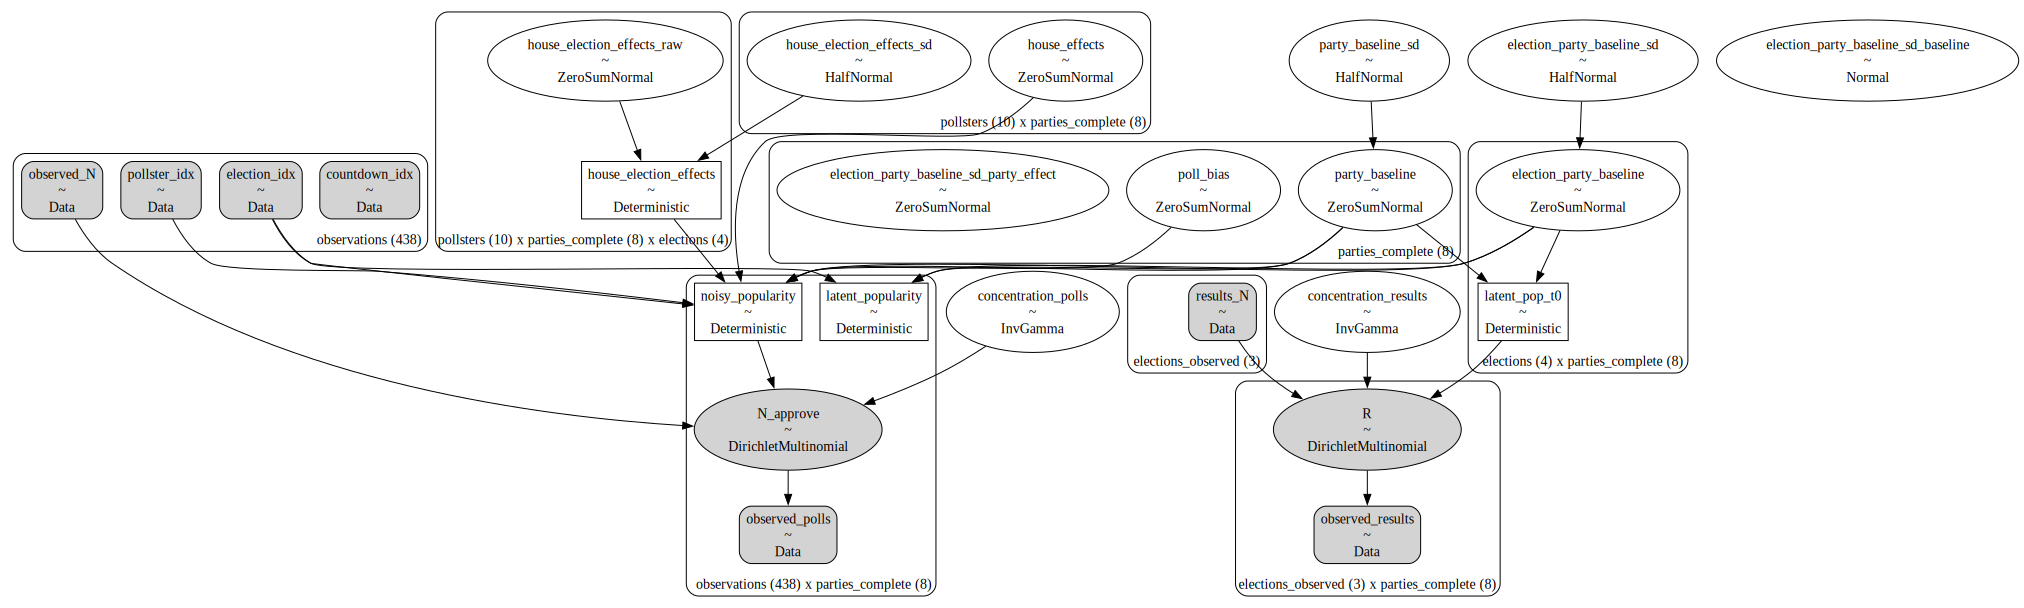

In [3]:
model = ElectionsModel('2024-03-10')
pm.model_to_graphviz(model.build_model())

In [4]:
prior,trace,post = model.sample_all(
    var_names=[
        "latent_popularity",
        "latent_pop_t0",
        "R",
        "noisy_popularity",
        "N_approve",
    ],
)

Sampling: [N_approve, R, concentration_polls, concentration_results, election_party_baseline, election_party_baseline_sd, election_party_baseline_sd_baseline, election_party_baseline_sd_party_effect, house_effects, house_election_effects_raw, house_election_effects_sd, party_baseline, party_baseline_sd, poll_bias]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/bernardo.caldas/miniforge3/envs/bayes3/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1011: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,1000,7]), ShapedArray(float64[4,1000,7]), ShapedArray(float64[4,1000,4,7]), ShapedArray(float64[4,1000,7]), ShapedArray(float64[4,1000,10,7]), ShapedArray(float64[4,1000,9,7,3]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
Sampling: [N_approve, R, election_party_baseline, house_election_effects_raw]


Output()

In [5]:
arviz.to_netcdf(prior, "prior.nc")
arviz.to_netcdf(trace, "trace.nc")
arviz.to_netcdf(post, "posterior.nc")


'posterior.nc'

In [7]:
if 'prior' not in locals():
    prior = arviz.from_netcdf("prior.nc")
if 'trace' not in locals():
    trace = arviz.from_netcdf("trace.nc")
if 'posterior' not in locals():
    posterior = arviz.from_netcdf("posterior.nc")



array([[<Axes: title={'center': 'house_effects'}>,
        <Axes: title={'center': 'house_effects'}>]], dtype=object)

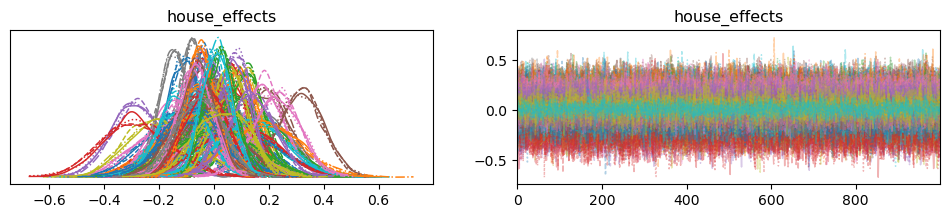

In [7]:
import arviz as az

#az.rcParams["plot.max_subplots"] = 200
az.plot_trace(trace, var_names=['house_effects'])

In [8]:
trace.posterior

<xarray.Dataset> Size: 253MB
Dimensions:                                  (chain: 4, draw: 1000,
                                              elections: 4,
                                              parties_complete: 8,
                                              pollsters: 10, observations: 438)
Coordinates:
  * chain                                    (chain) int64 32B 0 1 2 3
  * draw                                     (draw) int64 8kB 0 1 2 ... 998 999
  * elections                                (elections) datetime64[ns] 32B 2...
  * parties_complete                         (parties_complete) <U3 96B 'PS' ...
  * pollsters                                (pollsters) <U19 760B 'Aximage' ...
  * observations                             (observations) int64 4kB 0 ... 280
Data variables: (12/16)
    concentration_polls                      (chain, draw) float64 32kB 1.59e...
    concentration_results                    (chain, draw) float64 32kB 2.398...
    election_party_baseline                  (chain, draw, elections, parties_complete) float64 1MB ...
    election_party_baseline_sd               (chain, draw) float64 32kB 0.913...
    election_party_baseline_sd_baseline      (chain, draw) float64 32kB -0.08...
    election_party_baseline_sd_party_effect  (chain, draw, parties_complete) float64 256kB ...
    ...                                       ...
    latent_pop_t0                            (chain, draw, elections, parties_complete) float64 1MB ...
    latent_popularity                        (chain, draw, observations, parties_complete) float64 112MB ...
    noisy_popularity                         (chain, draw, observations, parties_complete) float64 112MB ...
    party_baseline                           (chain, draw, parties_complete) float64 256kB ...
    party_baseline_sd                        (chain, draw) float64 32kB 1.005...
    poll_bias                                (chain, draw, parties_complete) float64 256kB ...
Attributes:
    created_at:                 2024-09-13T13:20:51.617371+00:00
    arviz_version:              0.19.0
    inference_library:          numpyro
    inference_library_version:  0.15.2
    sampling_time:              467.912998
    tuning_steps:               1000

In [34]:

df = pd.DataFrame()
df = trace.posterior['house_effects'].mean(axis=0).mean(axis=0).to_dataframe()

df.groupby('pollster').mean().plot(kind="bar")


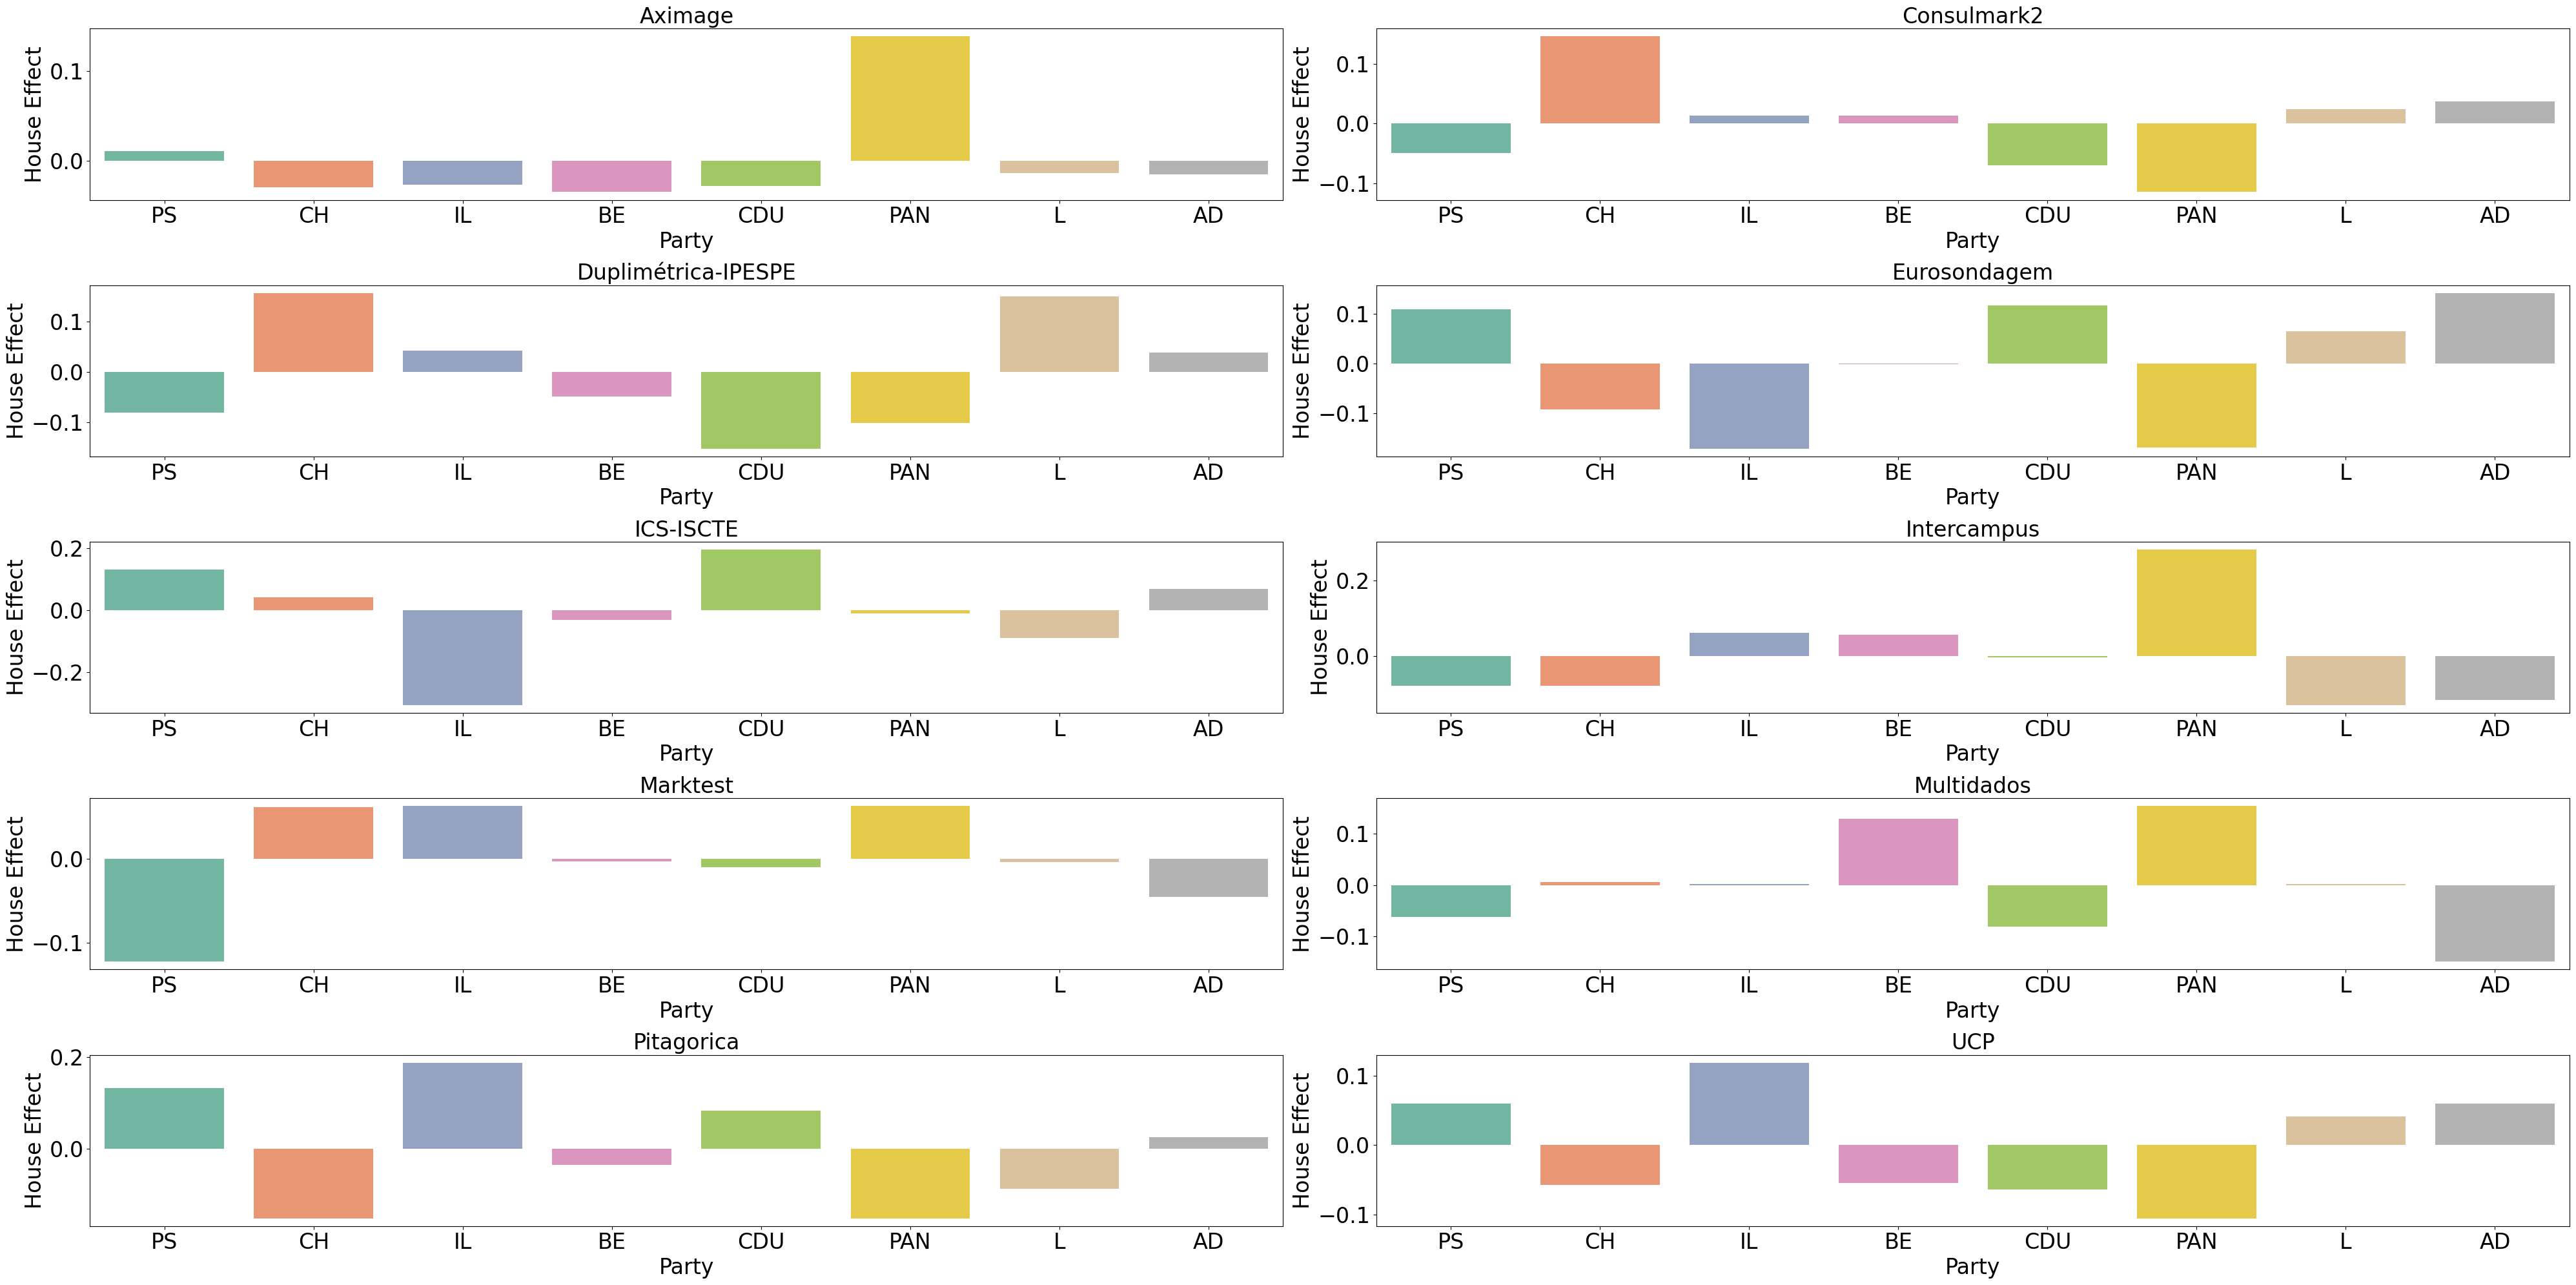

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape the dataframe for plotting
df_plot = df.reset_index()

# Calculate the number of rows and columns for subplots
num_pollsters = len(df_plot['pollsters'].unique())
num_rows = (num_pollsters + 1) // 2
num_cols = min(num_pollsters, 2)

# Set the figure size and create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, 20))

# Iterate over each pollster
for i, pollster in enumerate(df_plot['pollsters'].unique()):
    # Create a subplot for each pollster
    ax = axes[i // num_cols, i % num_cols]
    
    # Filter the data for the current pollster
    data = df_plot[df_plot['pollsters'] == pollster]
    
    # Plot the house effects per party
    sns.barplot(data=data, x='parties_complete', y='house_effects', hue='parties_complete', palette='Set2', ax=ax, legend=False)
    
    # Set the title and labels with increased font size
    ax.set_title(pollster, fontsize=24)
    ax.set_xlabel('Party', fontsize=24)
    ax.set_ylabel('House Effect', fontsize=24)
    
    # Increase the font size of tick labels
    ax.tick_params(axis='both', which='major', labelsize=24)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
polls_train = a.polls_train.copy()
retrodictive_plot(
    trace.sel(
        elections="2022-01-30",
        observations=polls_train[polls_train.election_date == "2022-01-30"].index,
    ),
    a.political_families,
    polls_train[polls_train.election_date == "2022-01-30"],
    group="prior",
)

In [ ]:
arviz.to_netcdf(trace, "../trace.nc")


In [ ]:
arviz.plot_trace(trace, var_names='latent_popularity')

In [ ]:
post_2.set_coords()

In [ ]:
temp_results_df.drop(columns='territoryName').sum()

In [14]:
retrodictive_plot(
    trace_2.sel(
        elections="2022-01-30",
        observations=a.polls_train[a.polls_train.election_date == "2022-01-30"].index,
    ),
    post_2.sel(
        elections="2022-01-30",
        observations=a.polls_train[a.polls_train.election_date == "2022-01-30"].index,
    ),
    a.political_families,
    a.polls_train[a.polls_train.election_date == "2022-01-30"],
    group="posterior",
)

NameError: name 'a' is not defined

In [4]:
post_2

NameError: name 'post_2' is not defined

In [3]:
trace_2 = arviz.from_netcdf("trace.nc")

In [8]:
election_forecast

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [4]:
election_forecast = b.forecast_election(trace_2)


/opt/conda/lib/python3.11/site-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.

In [5]:
election_forecast,PREDICTION_COORDS,PREDICTION_DIMS = election_forecast

In [6]:
election_forecast.assign_coords(coords=PREDICTION_COORDS, inplace=True)

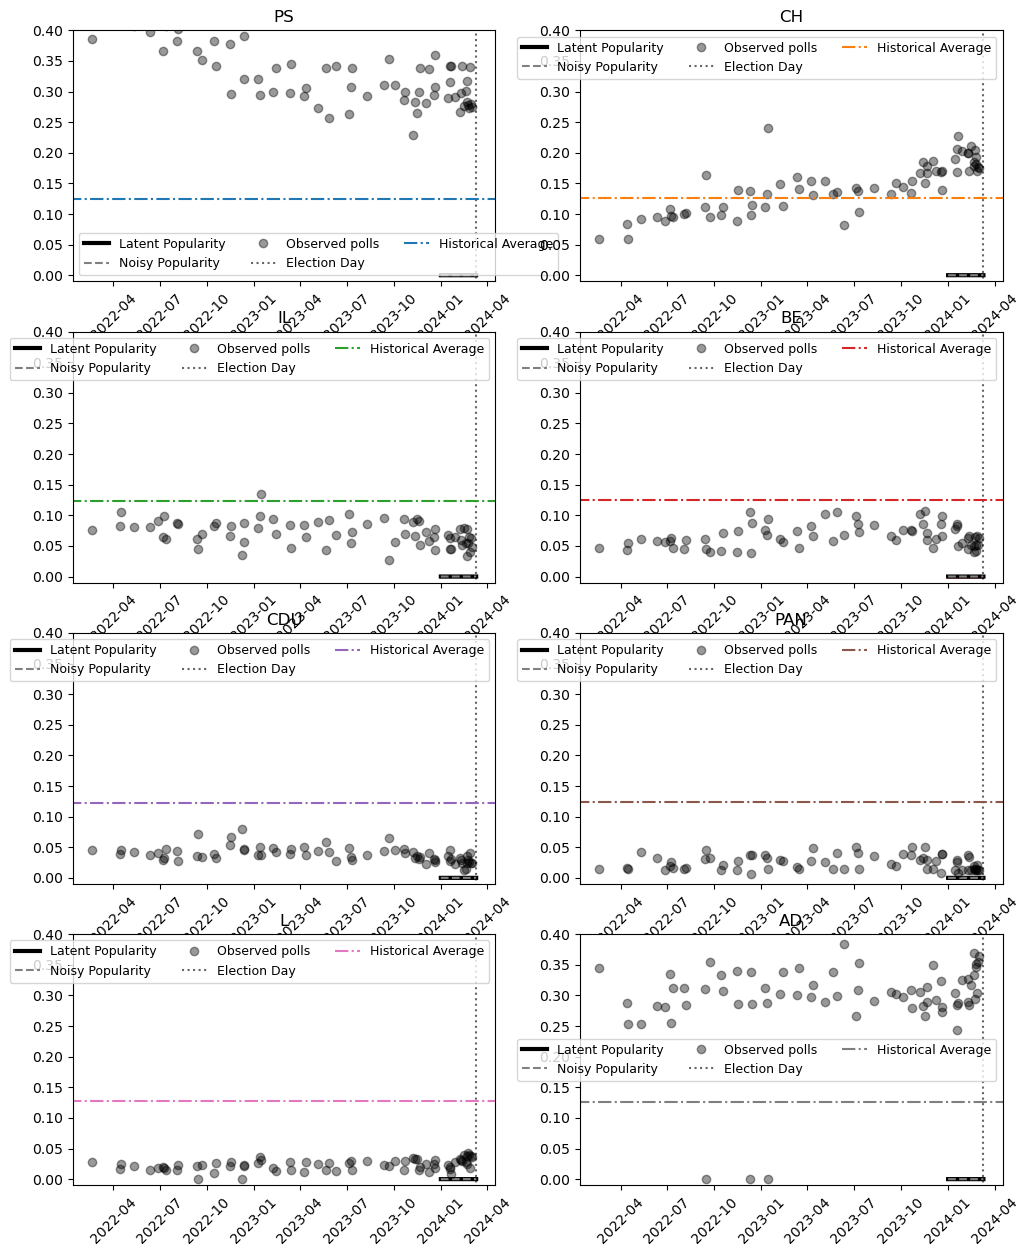

In [7]:
predictive_plot(
    idata=election_forecast,
    parties_complete=b.political_families,
    election_date="2024-03-10",
    polls_train=b.polls_train[b.polls_train.election_date == "2024-03-10"],
    polls_test=None,
)